In [1]:
!pip install ucimlrepo --quiet
!pip install umap-learn --quiet
!pip install trimap --quiet
!pip install pacmap --quiet
!pip install scikit-fuzzy --quiet

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from umap import UMAP
from trimap import TRIMAP
from pacmap import PaCMAP
import skfuzzy as fuzz
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
umap = UMAP(n_components=2, random_state=42)
trimap = TRIMAP()
pacmap = PaCMAP(n_components=2, random_state=42)
dbscan = DBSCAN(eps=3, min_samples=2)

In [3]:
def clusterisation_check(limit):
  models, score1, score2 = [], [], []

  # Для иерархической кластеризации
  for n_clusters in range(2, limit):
      model = AgglomerativeClustering(n_clusters)
      clusters = model.fit_predict(X_train)
      silhouette_avg = silhouette_score(X_train, clusters)
      # print(f"Иерархическая кластеризация с {n_clusters} кластерами - индекс силуэта: {silhouette_avg}")

  # Для итеративной кластеризации (K-means)
  silhouette_scores = []
  for n_clusters in range(2, limit):
      model = KMeans(n_clusters=n_clusters, random_state=42)
      clusters = model.fit_predict(X_train)
      silhouette_avg = silhouette_score(X_train, clusters)
      silhouette_scores.append(silhouette_avg)
      models.append(model)
      score1.append(model.inertia_)
      score2.append(silhouette_score(X_train, model.labels_))
      # print(f"K-means кластеризация с {n_clusters} кластерами - индекс силуэта: {silhouette_avg}")

  fig, ax = plt.subplots(1, 2, figsize=(15, 8))
  ax[0].grid()
  ax[0].set_title("Метод локтя")
  ax[0].plot(np.arange(2, limit), score1, marker = 'o')
  ax[1].grid()
  ax[1].set_title("Индекс силуэта")
  ax[1].plot(np.arange(2, limit), score2, marker = 'o')
  fig.show()

In [4]:
def dendrogram_vis():
  Z = linkage(X_train.values, 'ward')
  plt.figure(figsize=(12, 6))
  dendrogram(Z)
  plt.title('Dendrogram')
  plt.xlabel('Samples')
  plt.ylabel('Distance')
  plt.show()

  # Выбор оптимального числа кластеров
  max_d = 200  # Максимальное расстояние между кластерами
  clusters = fcluster(Z, max_d, criterion='distance')

  print("Число образованных кластеров:", len(np.unique(clusters)))
  print("Распределение по кластерам:")
  print(np.bincount(clusters))

In [5]:
def visualization(clustering, reduce, clusters):
  # Кластеризация данных
  if clustering == "kmeans":
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

  elif clustering == "skfuzzy":
    centers, U, _, _, _, _, _ = fuzz.cluster.cmeans(X_train.T, c=clusters, m=2, error=0.005, maxiter=1000, init=None)
    labels = np.argmax(U, axis=0)

  # print("Координаты центроидов кластеров:")
  # print(centers)

  # Визуализация с использованием методов снижения размерности
  X_combined = np.vstack([X_train, centers])
  X_reduced_combined = reduce.fit_transform(X_combined)
  X_reduced = X_reduced_combined[:-centers.shape[0], :]
  centers_reduced = X_reduced_combined[-centers.shape[0]:, :]

  # Визуализация кластеров
  plt.figure(figsize=(10, 8))
  sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=labels, palette='Set1', legend='full')
  plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='black', s=200, alpha=0.9, marker='X')
  plt.title(f'K-means кластеризация с {str(reduce).split("(")[0]} визуализацией. Кластеров: {clusters}')
  plt.show()

In [6]:
def DBSCAN_vis(reduce):
  # Визуализация с использованием методов снижения размерности
  dbscan_clusters = dbscan.fit_predict(X_train)
  data_reduced = reduce.fit_transform(X_train)

  # Визуализация кластеров
  plt.figure(figsize=(12, 8))
  plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=dbscan_clusters, cmap='viridis', s=50)
  plt.title(f'DBSCAN Кластеризация с визуализацией {str(reduce).split("(")[0]}')
  plt.colorbar()
  plt.show()

In [7]:
def quality_check():
  kmeans = KMeans(n_clusters=2)
  kmeans.fit(X_train)

  # Предсказанные метки кластеров
  y_pred = kmeans.labels_
  y_true = np.asarray(Y_train).ravel()

  # Оценка качества кластеризации с использованием ARI
  ari = adjusted_rand_score(y_true, y_pred)
  print(f"Индекс Рэнда (ARI): {ari}")

  # Другие метрики качества кластеризации
  silhouette = silhouette_score(X_train, y_true)
  print(f"Индекс силуэта: {silhouette}")

# **Наборы данных с известными метками классов (кластеров) объектов.(echocardiogram)**

In [8]:
data = pd.read_csv("echocardiogram.csv").dropna()
target_columns = ['survival', 'alive', 'aliveat1']
feature_columns = [
    # 'survival', 'alive' , 'aliveat1',
    'age', 'pericardialeffusion', 'fractionalshortening',
    'epss', 'lvdd', 'wallmotion-score', 'wallmotion-index', 'mult'
]

X_train = data[feature_columns]
Y_train = data[target_columns[1]]
X_train

,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult
0,71.0,0.0,0.260,9.000,4.600,14.00,1.00,1.000
1,72.0,0.0,0.380,6.000,4.100,14.00,1.70,0.588
2,55.0,0.0,0.260,4.000,3.420,14.00,1.00,1.000
3,60.0,0.0,0.253,12.062,4.603,16.00,1.45,0.788
4,57.0,0.0,0.160,22.000,5.750,18.00,2.25,0.571
...,...,...,...,...,...,...,...,...
105,63.0,0.0,0.300,6.900,3.520,18.16,1.51,0.857
106,59.0,0.0,0.170,14.300,5.490,13.50,1.50,0.643
107,57.0,0.0,0.228,9.700,4.290,11.00,1.00,0.786
109,78.0,0.0,0.230,40.000,6.230,14.00,1.40,0.714


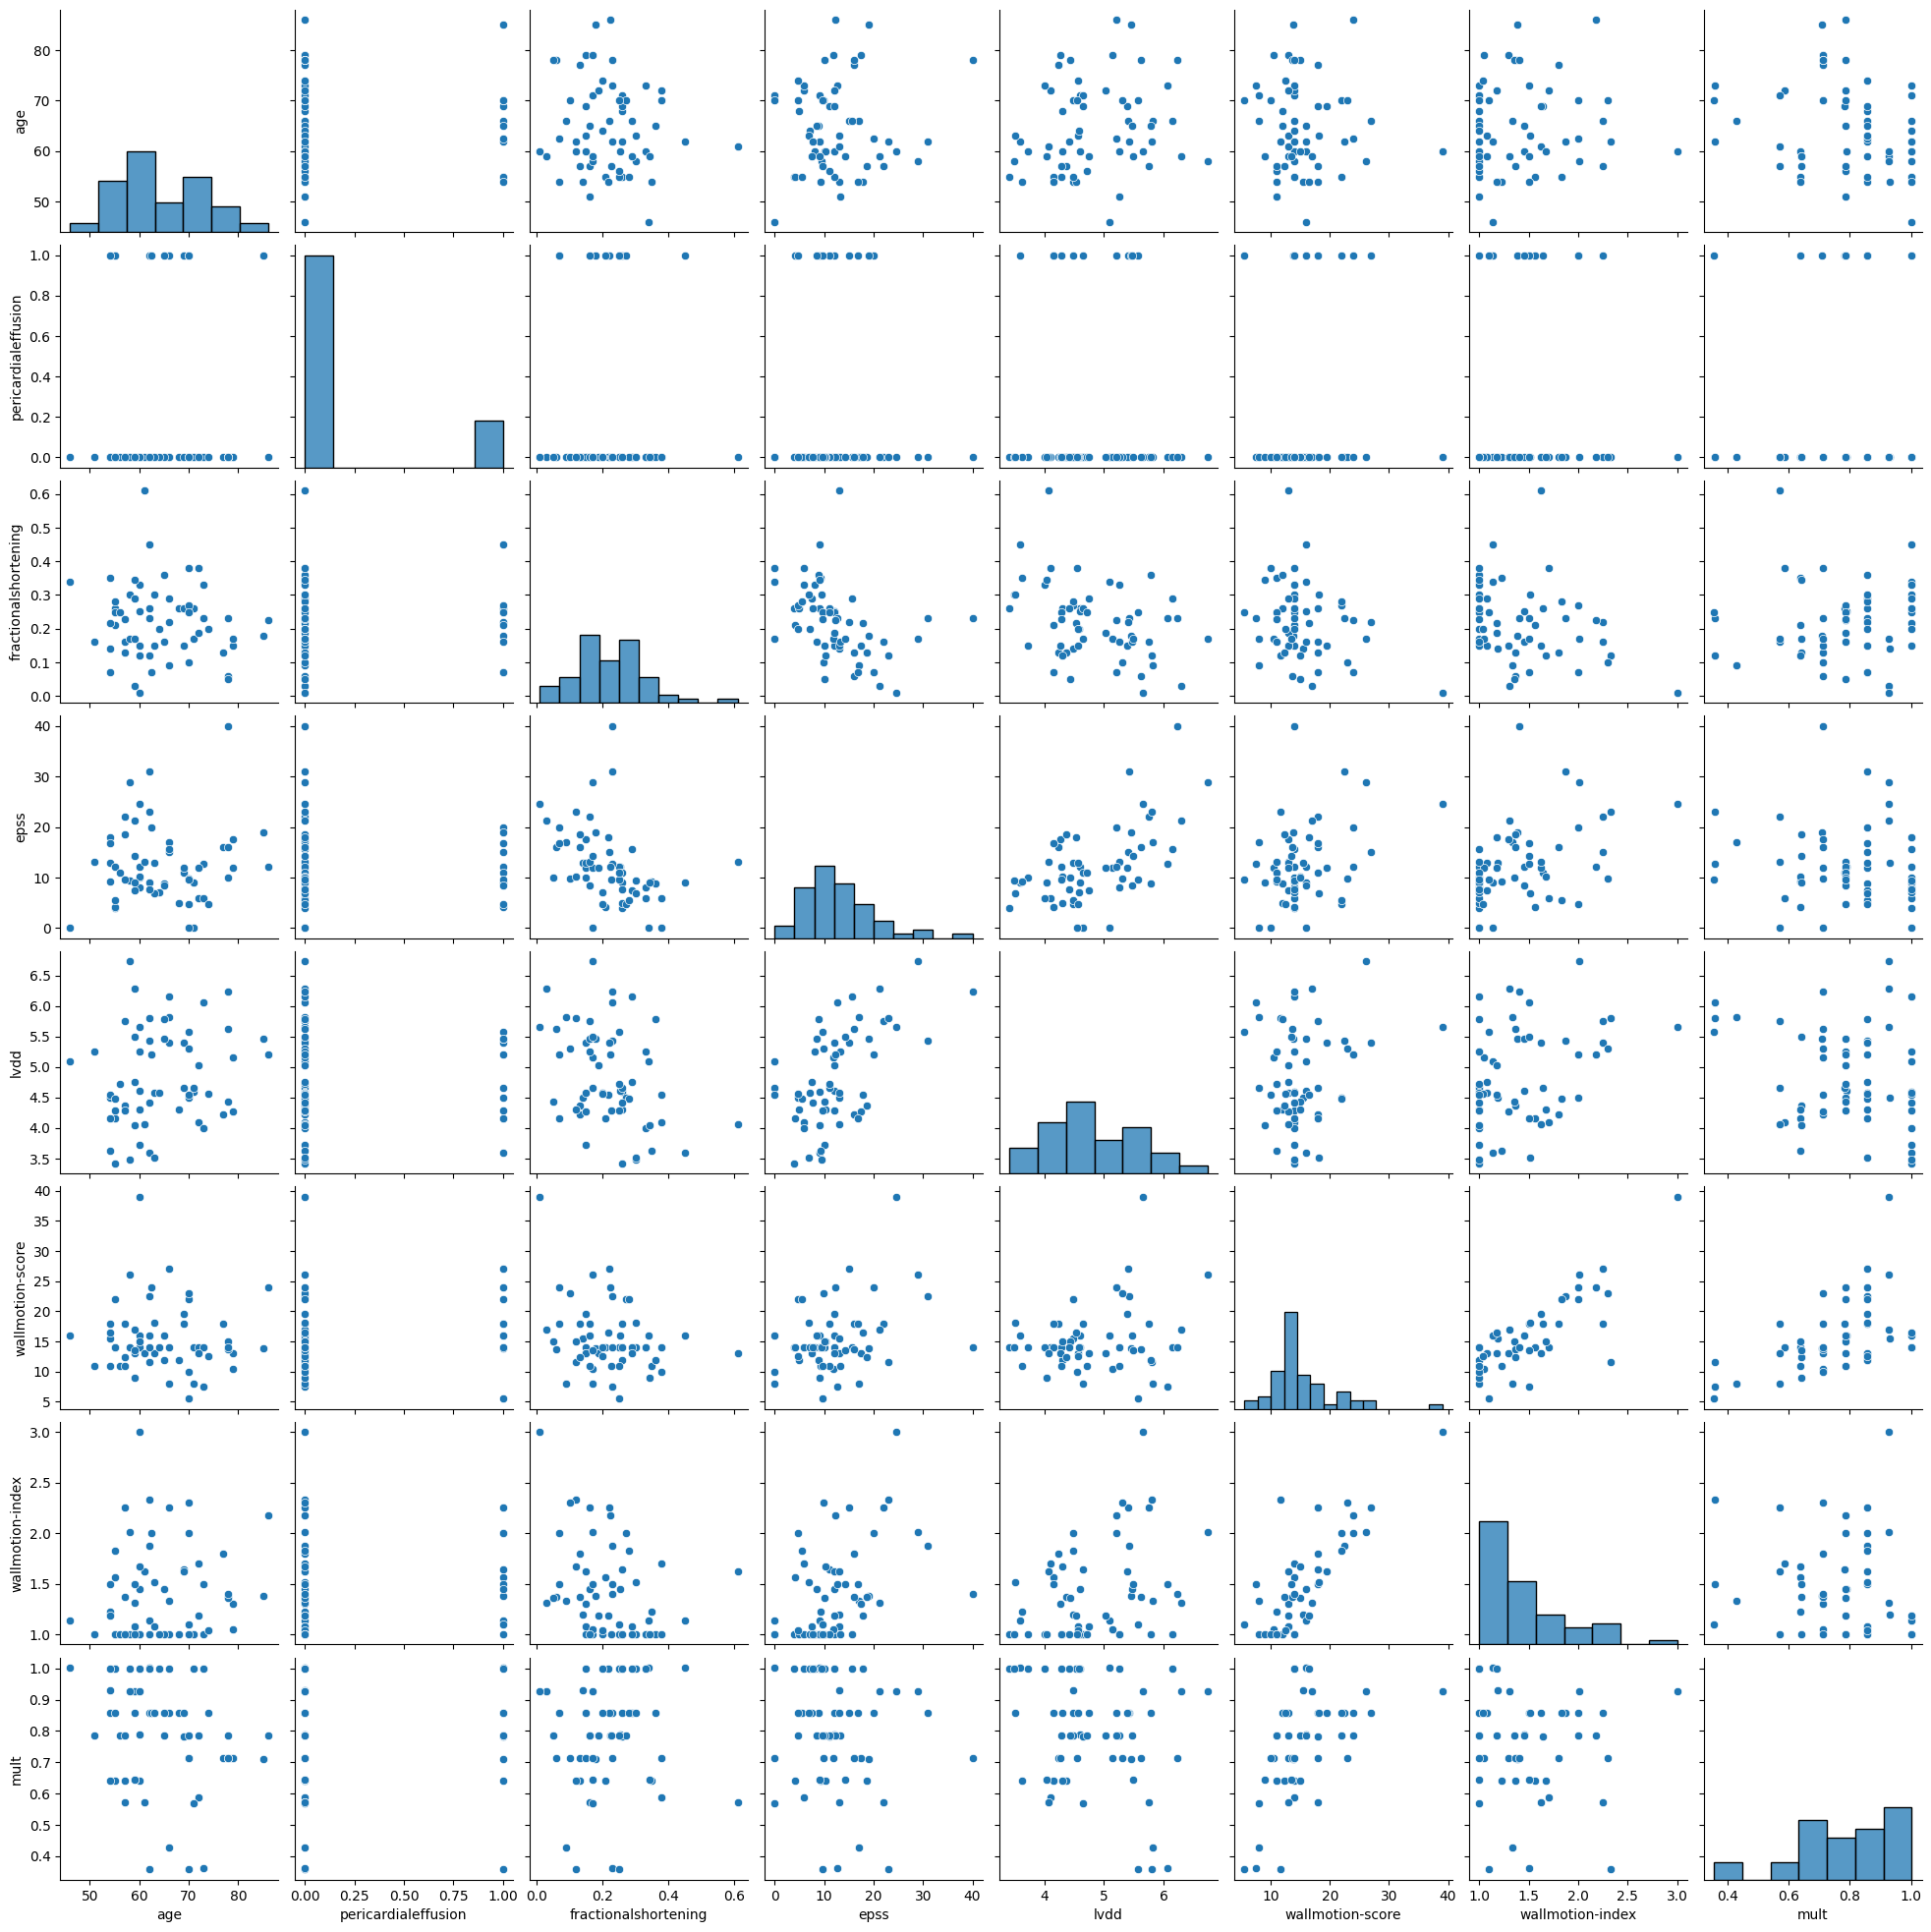

In [9]:
# Визуализация данных
sns.pairplot(X_train, diag_kind='hist')
plt.show()

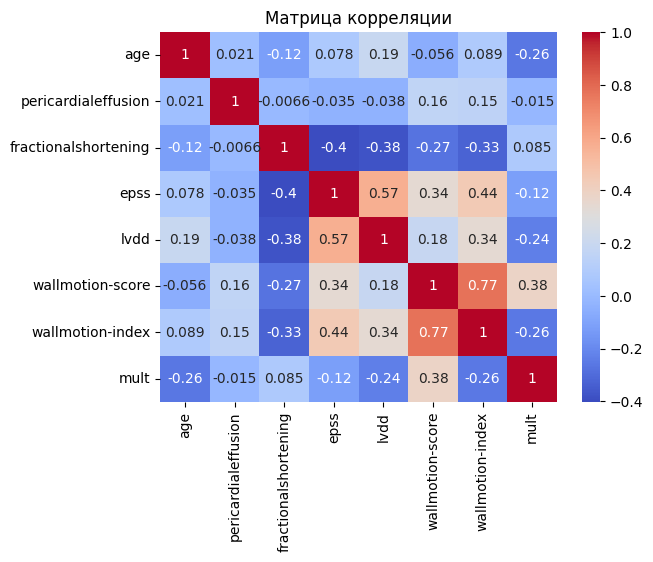

In [10]:
# Корреляционная матрица
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

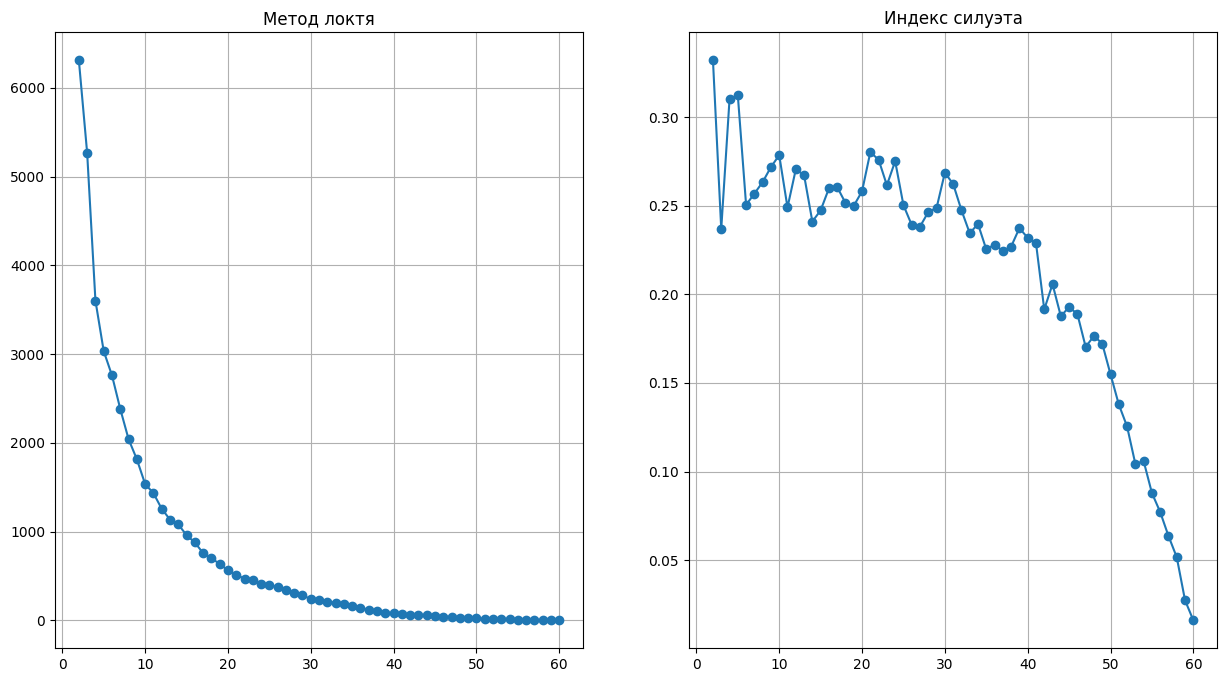

In [11]:
clusterisation_check(61)

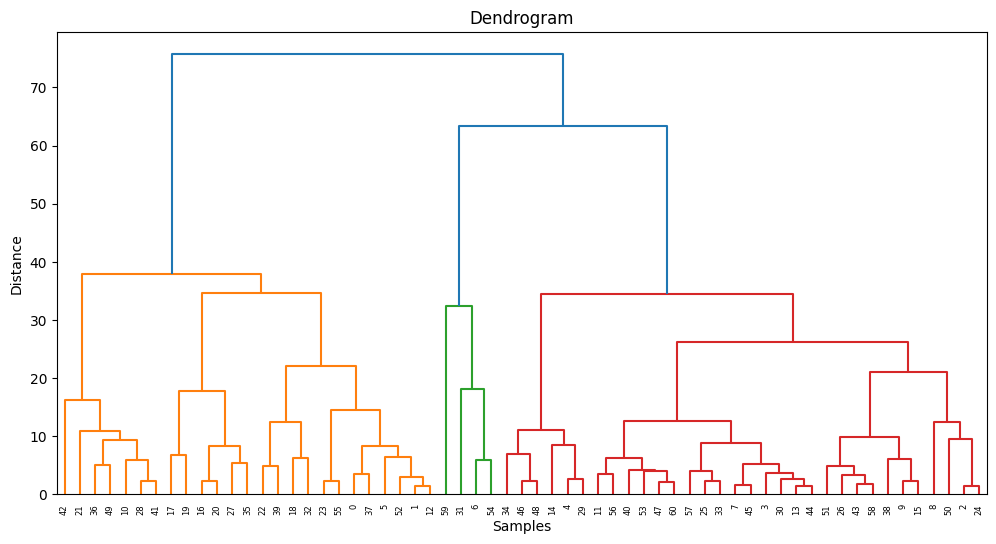

Число образованных кластеров: 1
Распределение по кластерам:
[ 0 61]


In [12]:
dendrogram_vis()

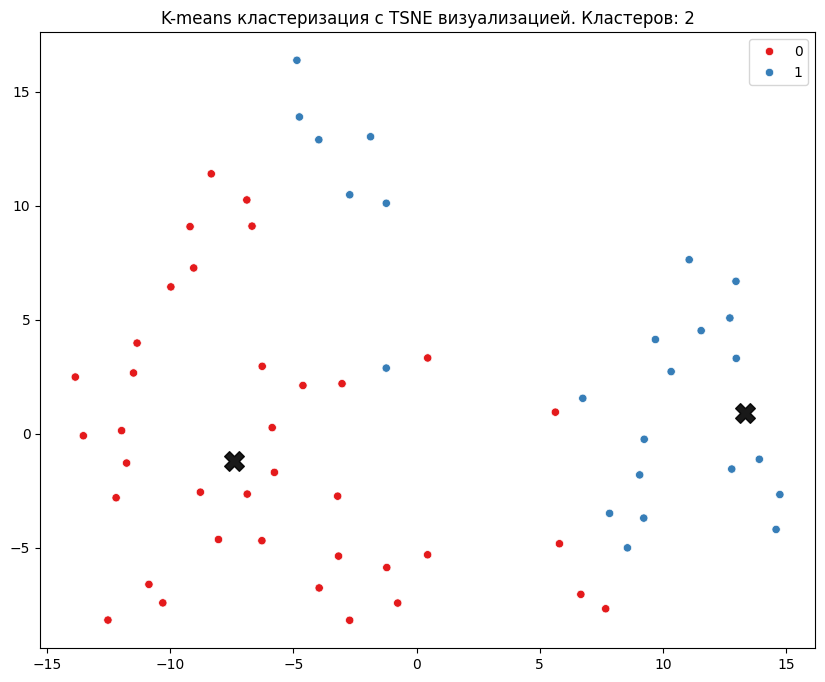

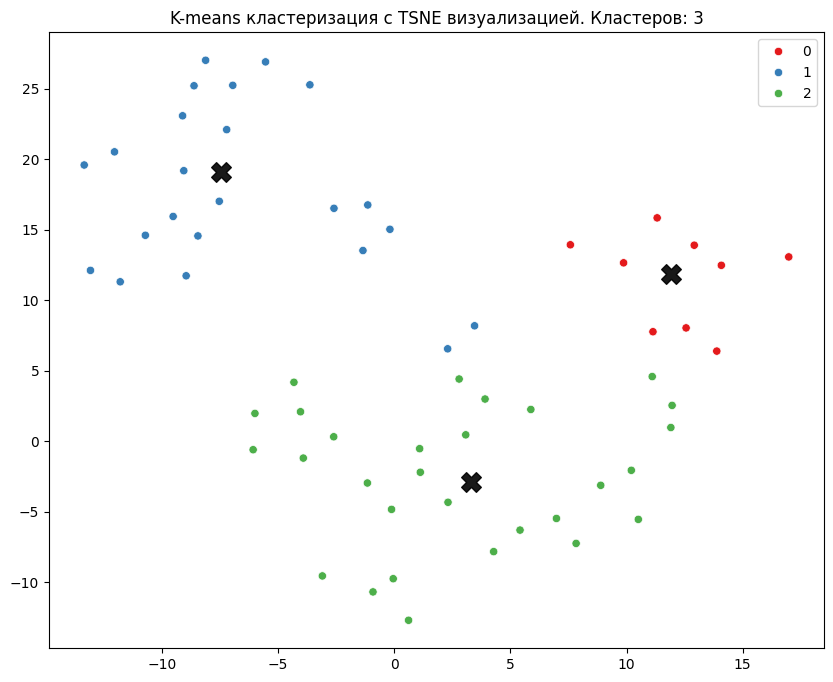

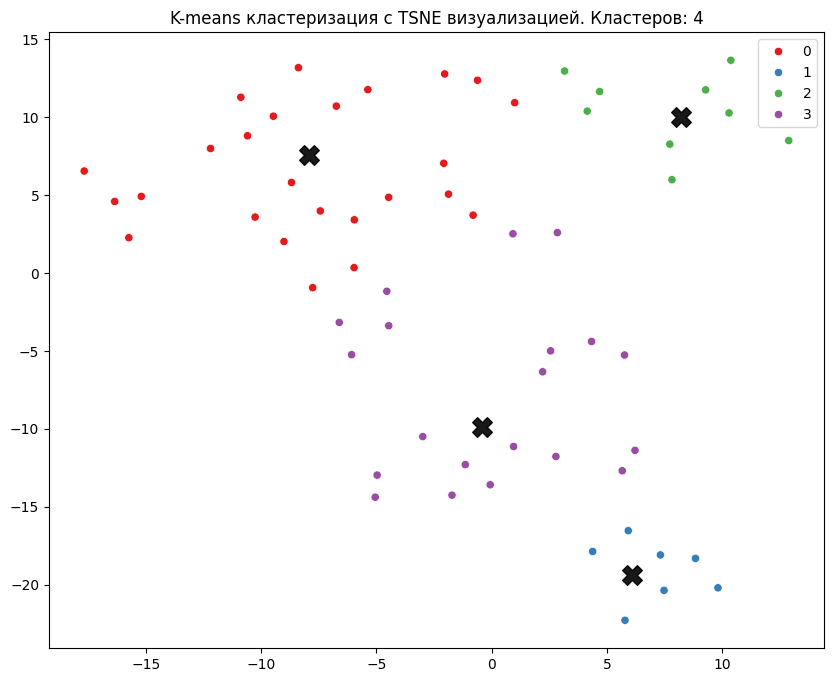

In [13]:
visualization("kmeans", tsne, 2)
visualization("kmeans", tsne, 3)
visualization("kmeans", tsne, 4)

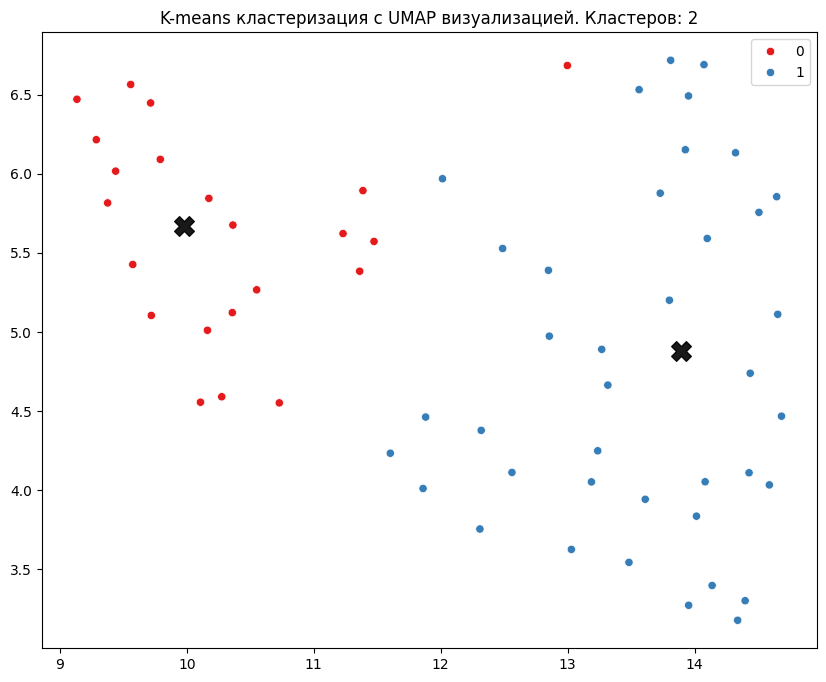

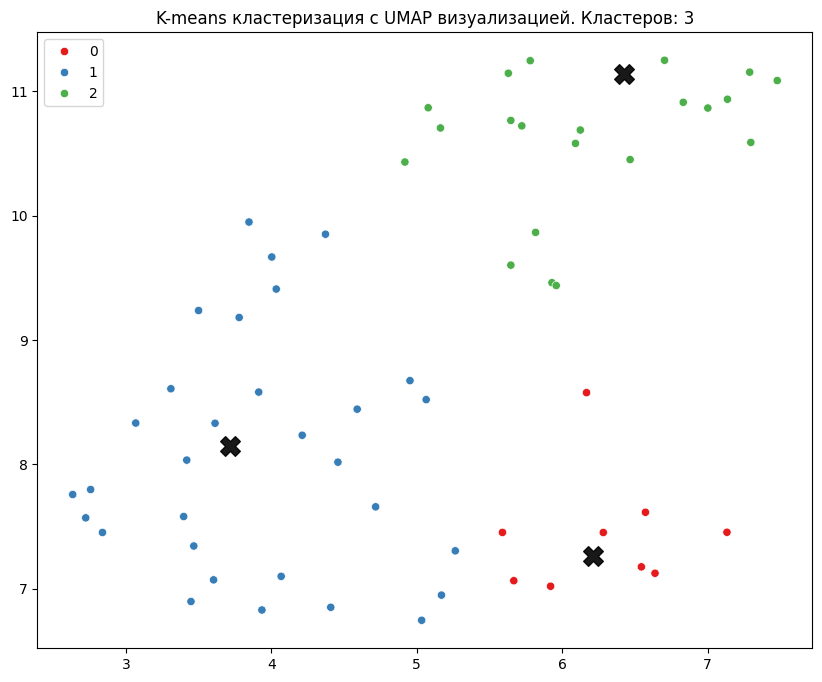

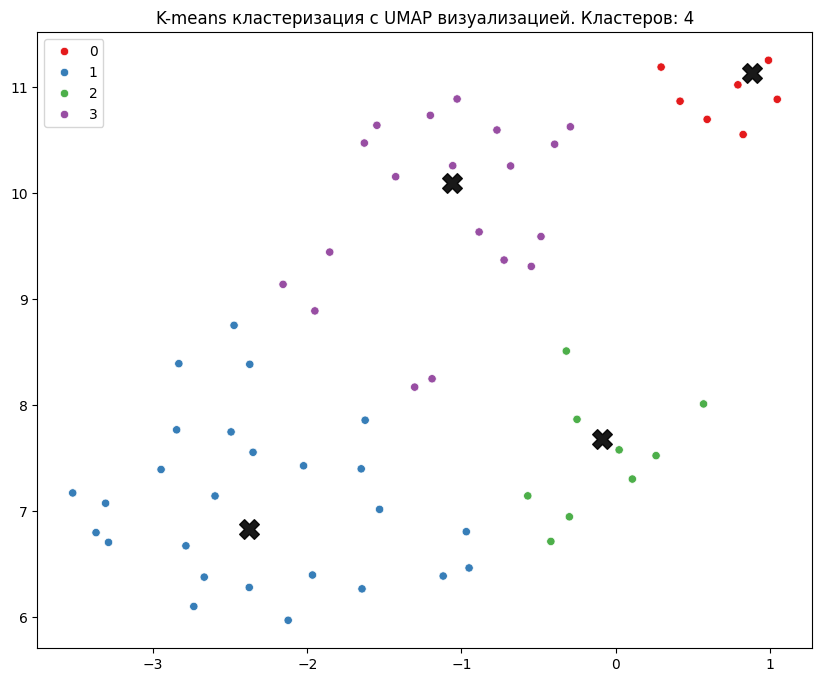

In [14]:
visualization("kmeans", umap, 2)
visualization("kmeans", umap, 3)
visualization("kmeans", umap, 4)

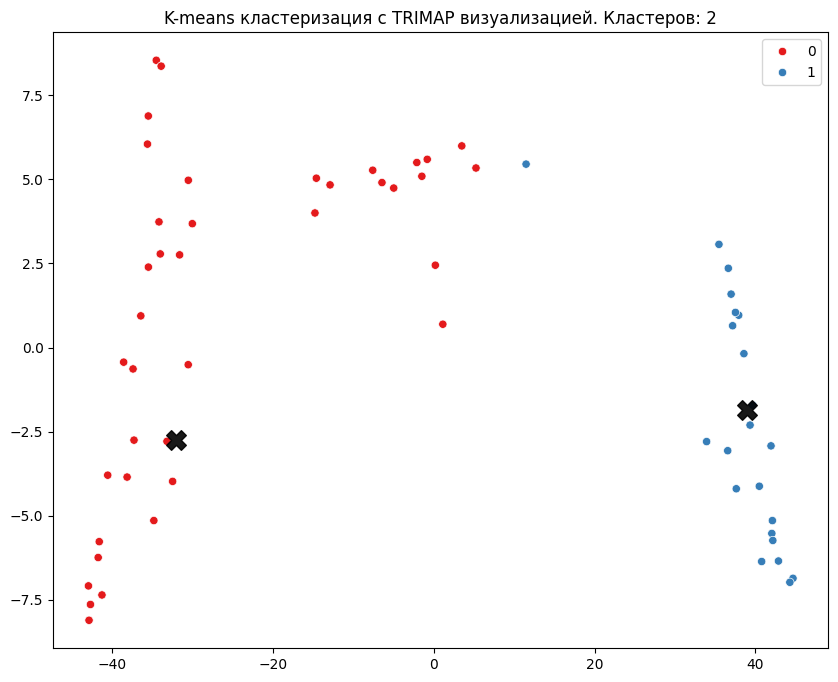

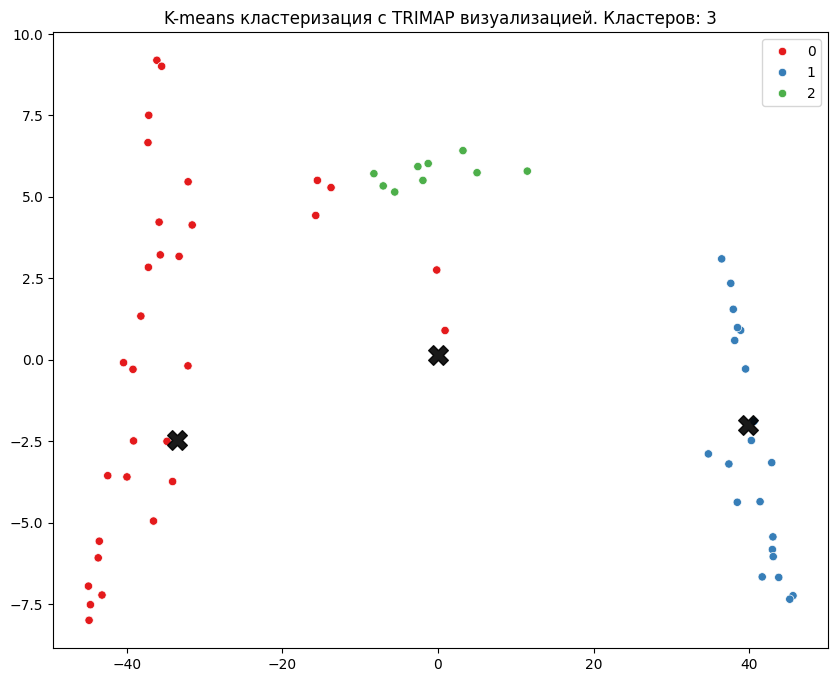

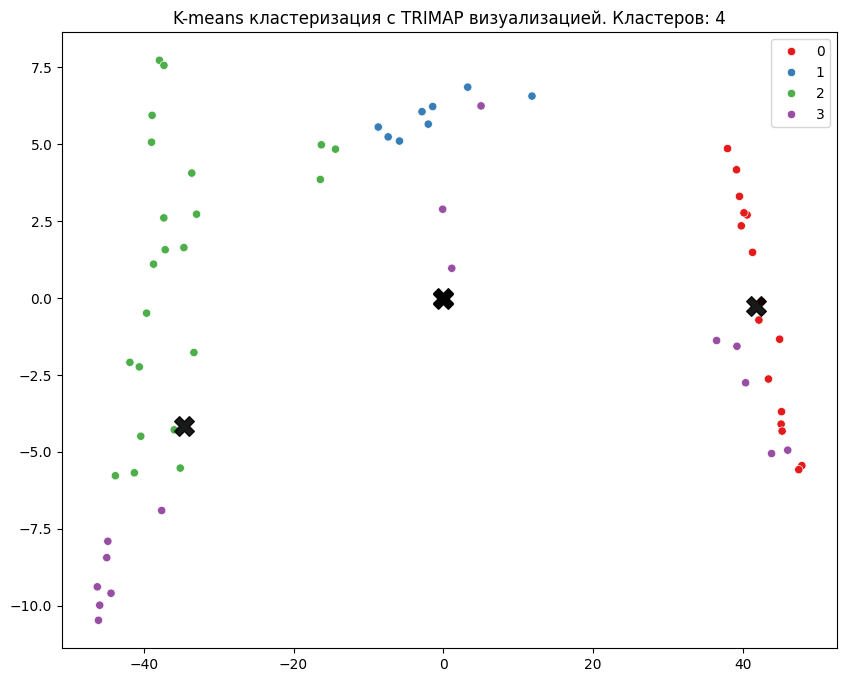

In [15]:
visualization("kmeans", trimap, 2)
visualization("kmeans", trimap, 3)
visualization("kmeans", trimap, 4)

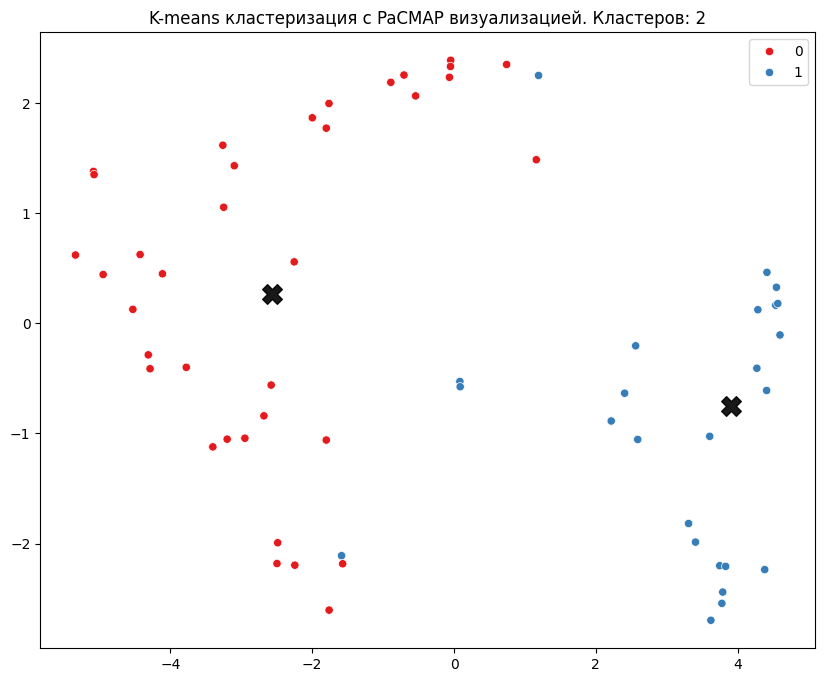

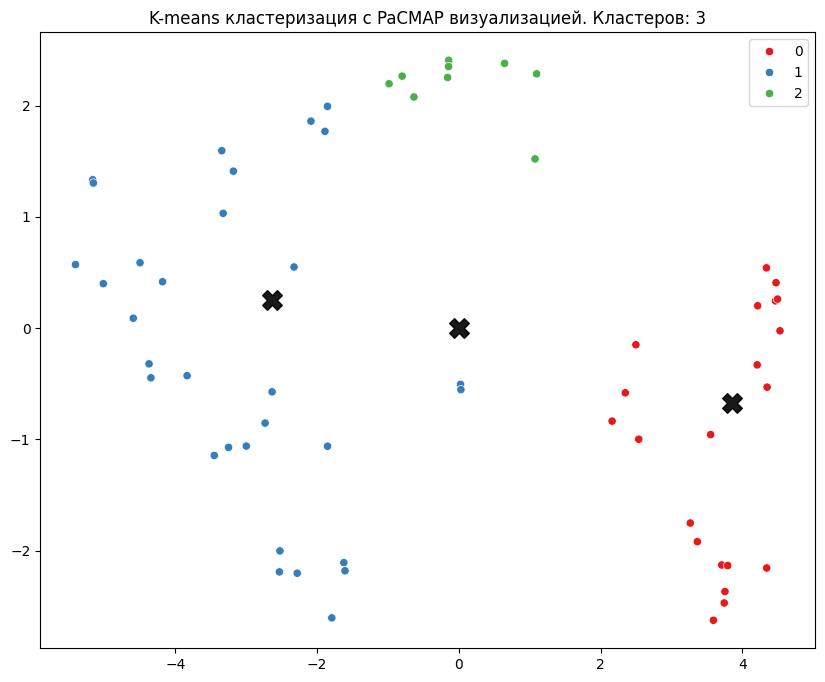

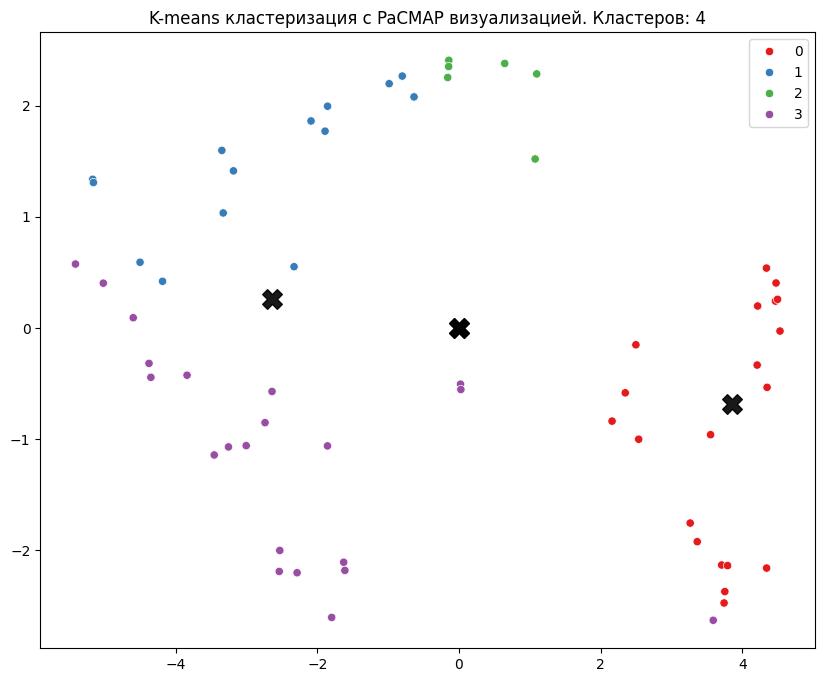

In [16]:
visualization("kmeans", pacmap, 2)
visualization("kmeans", pacmap, 3)
visualization("kmeans", pacmap, 4)

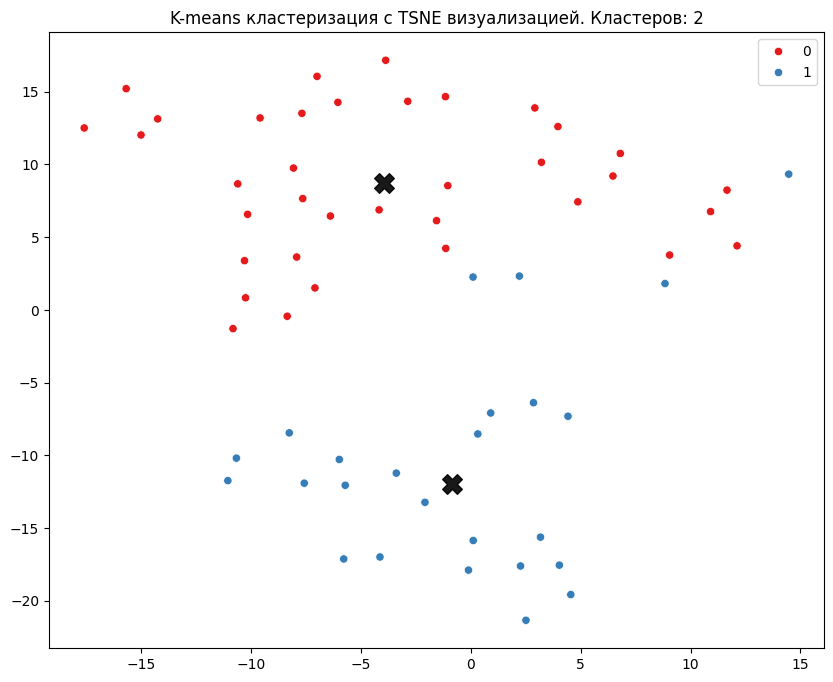

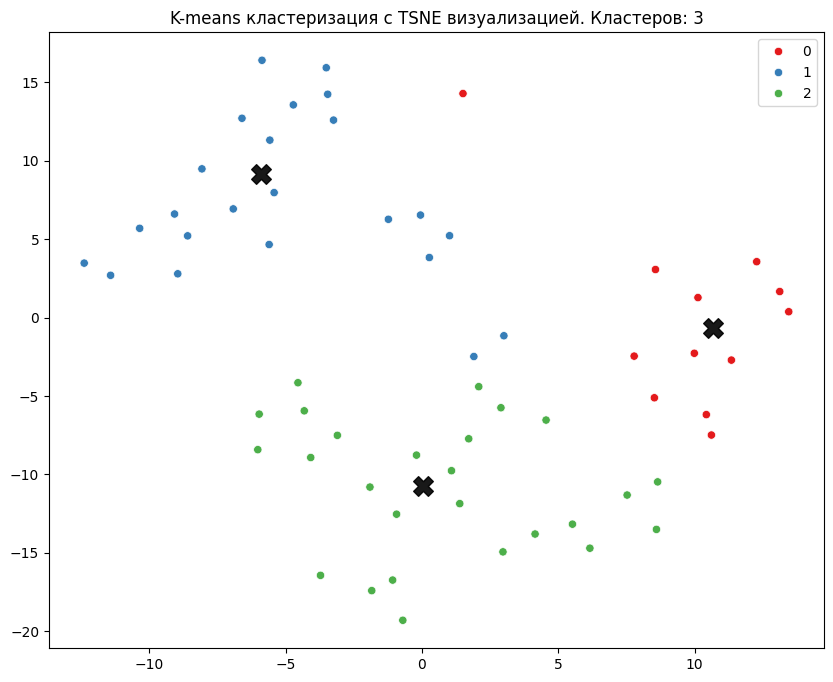

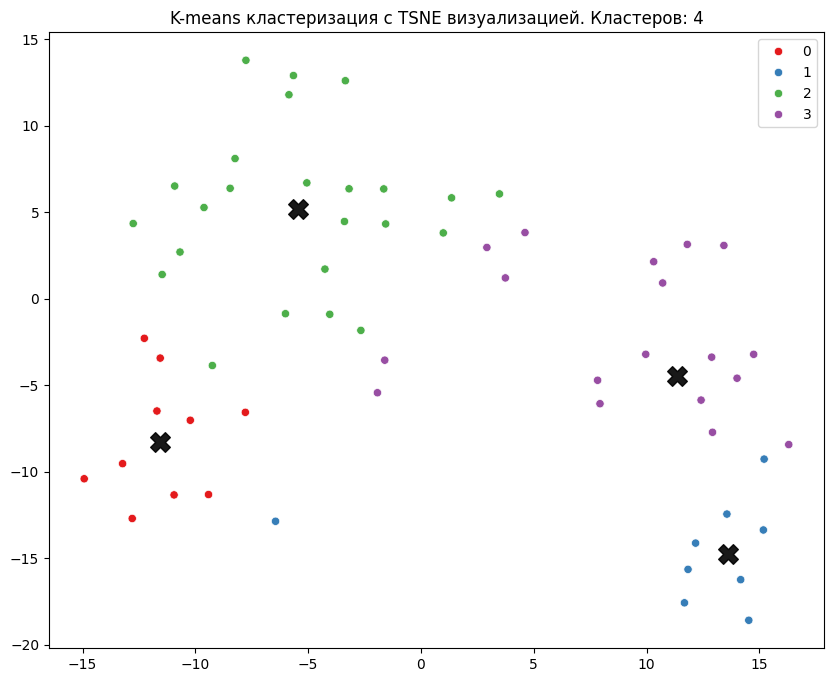

In [17]:
visualization("skfuzzy", tsne, 2)
visualization("skfuzzy", tsne, 3)
visualization("skfuzzy", tsne, 4)

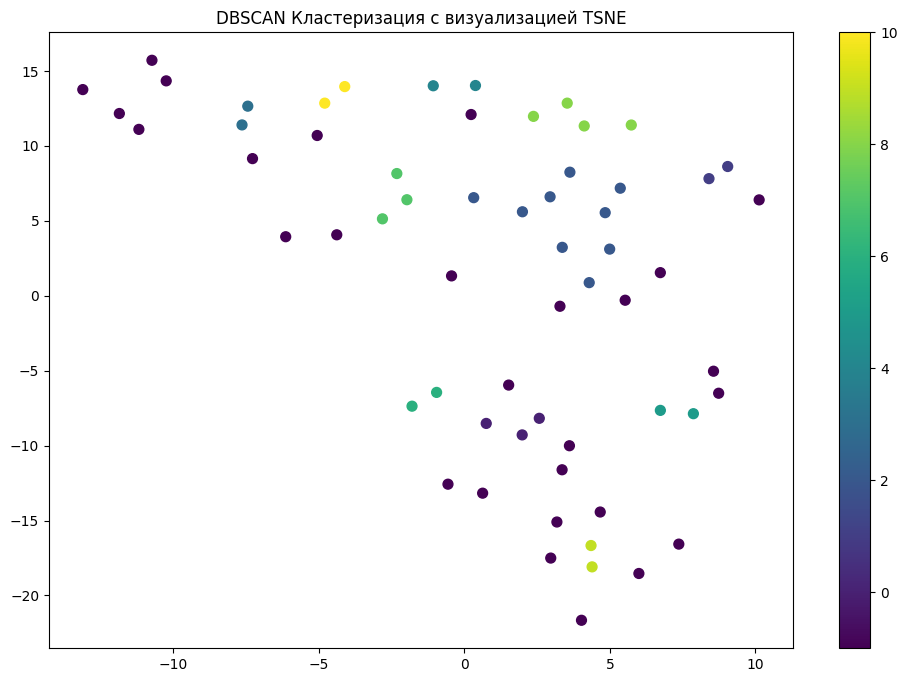

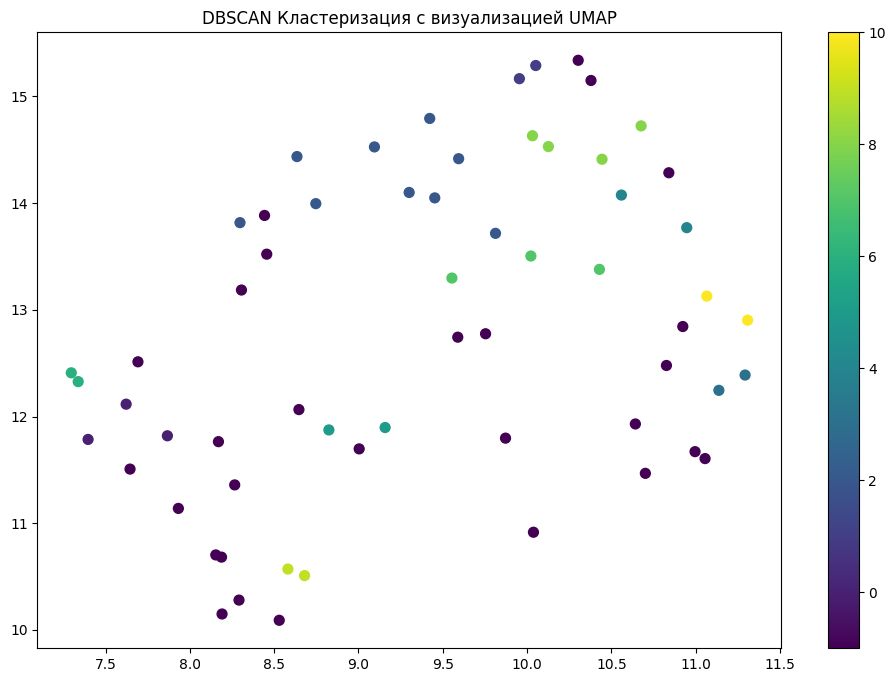

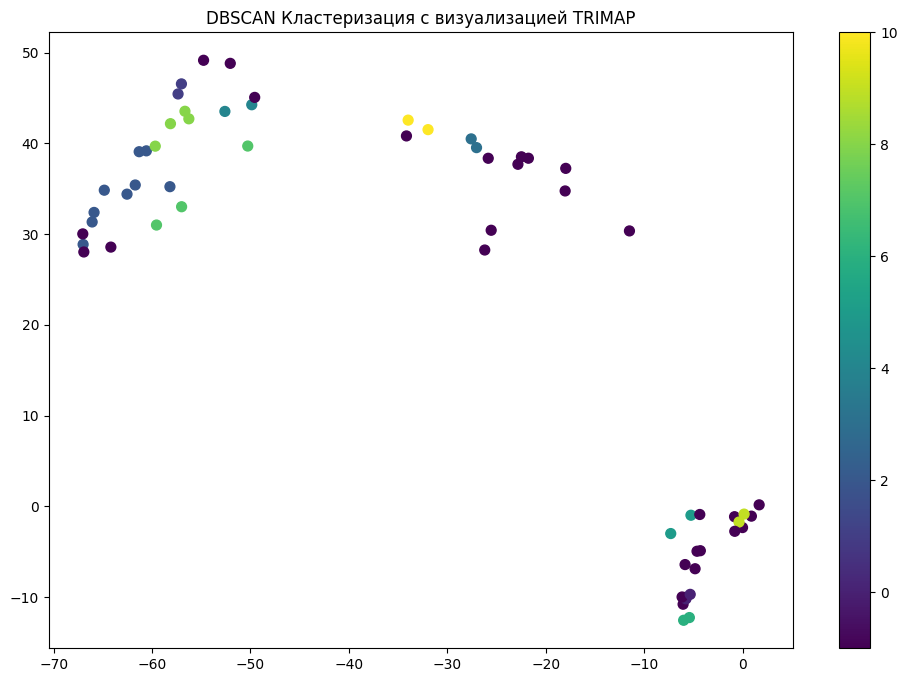

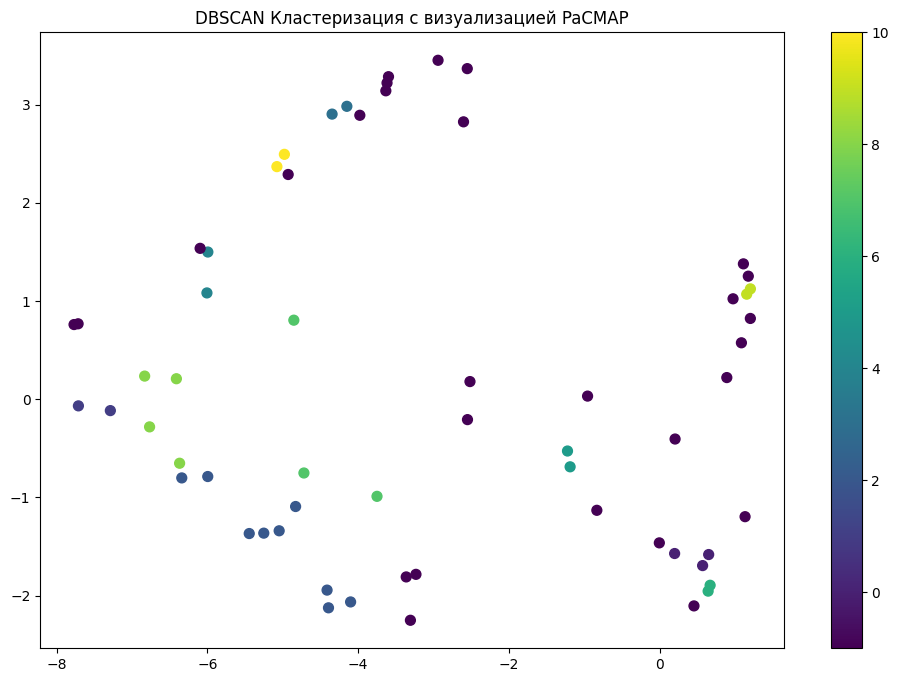

In [18]:
DBSCAN_vis(tsne)
DBSCAN_vis(umap)
DBSCAN_vis(trimap)
DBSCAN_vis(pacmap)

In [19]:
quality_check()

Индекс Рэнда (ARI): 0.02820236813778256
Индекс силуэта: 0.1416730177975344


# **Наборы aданных с неизвестными метками классов (кластеров) объектов. (lastfm)**

In [4]:
X_train = pd.read_csv("lastfm_train.csv", header=None).dropna()
X_train

,0,1,2
0,0,65,24
1,0,102,86
2,0,161,2
3,0,166,1
4,0,176,4
...,...,...,...
501514,991,15134,25
501515,991,15157,51
501516,991,15257,2
501517,991,15605,1


In [ ]:
clusterisation_check(10)

In [ ]:
dendrogram_vis()

In [ ]:
visualization("kmeans", tsne, 2)
visualization("kmeans", tsne, 3)
visualization("kmeans", tsne, 4)

In [ ]:
visualization("kmeans", umap, 2)
visualization("kmeans", umap, 3)
visualization("kmeans", umap, 4)

In [ ]:
visualization("kmeans", trimap, 2)
visualization("kmeans", trimap, 3)
visualization("kmeans", trimap, 4)

In [ ]:
visualization("kmeans", pacmap, 2)
visualization("kmeans", pacmap, 3)
visualization("kmeans", pacmap, 4)